In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
#from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [3]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


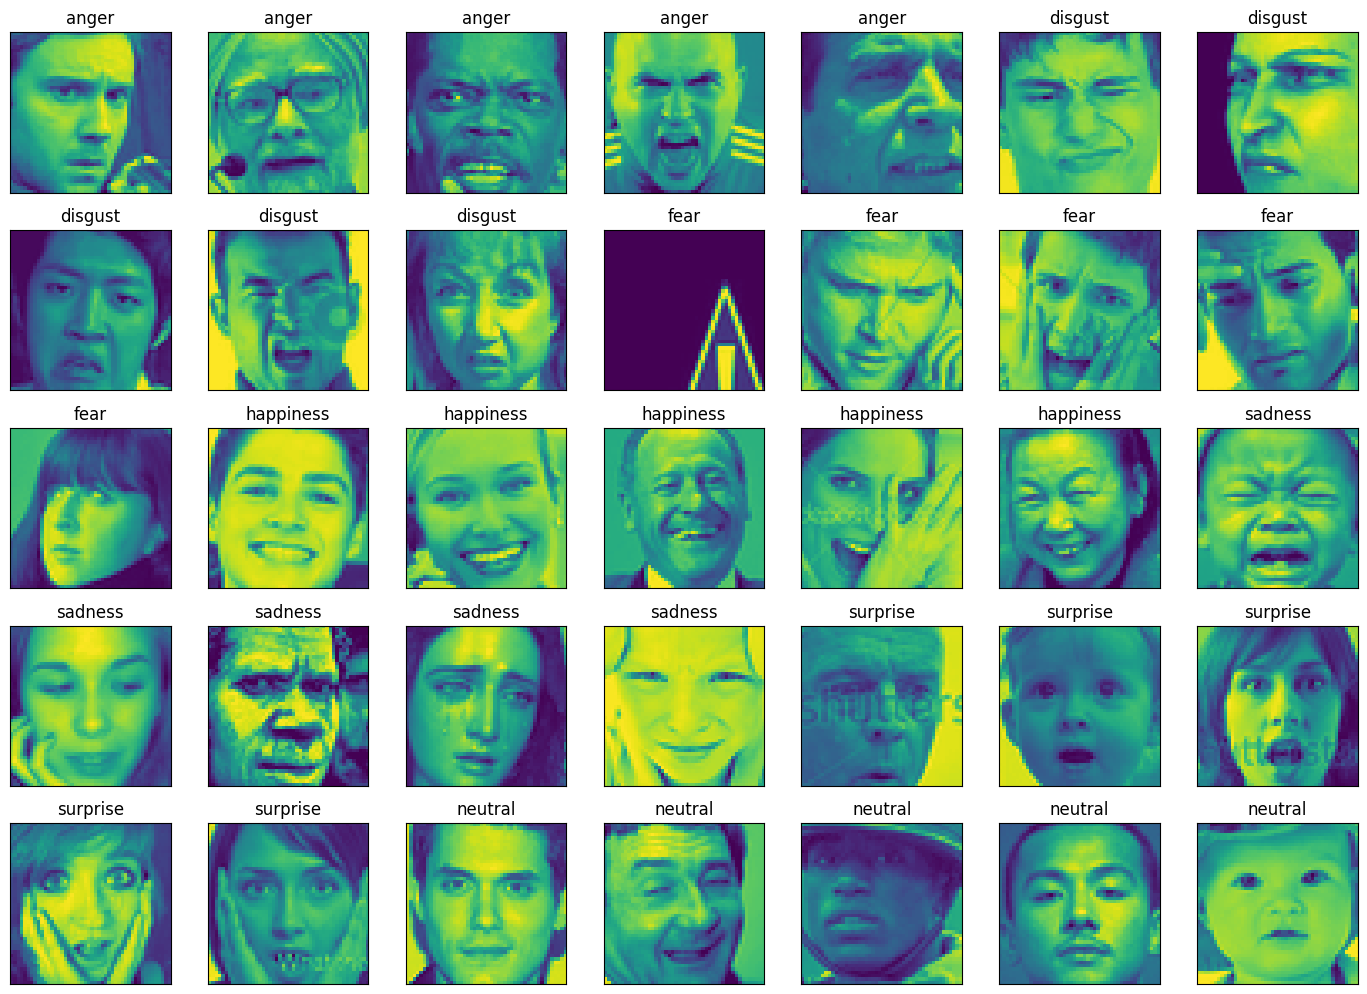

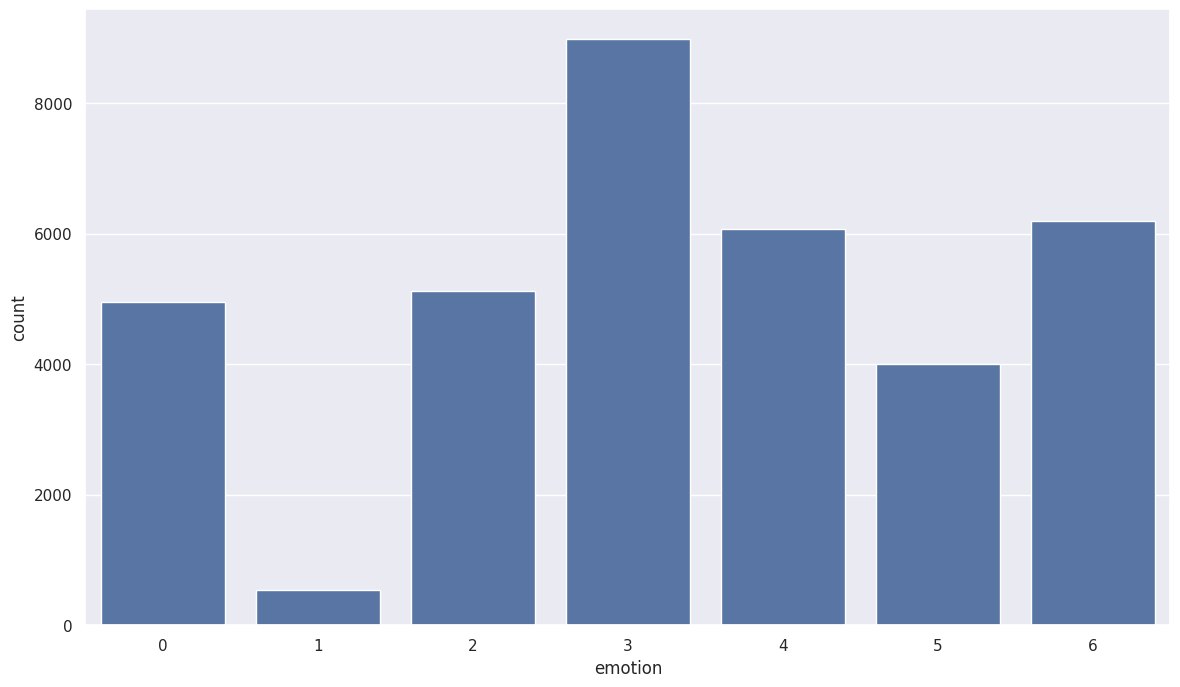

In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [5]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [6]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)


y_data.value_counts()

(62923, 1)   (62923,)


,count
emotion,
0,8989
2,8989
4,8989
6,8989
3,8989
5,8989
1,8989


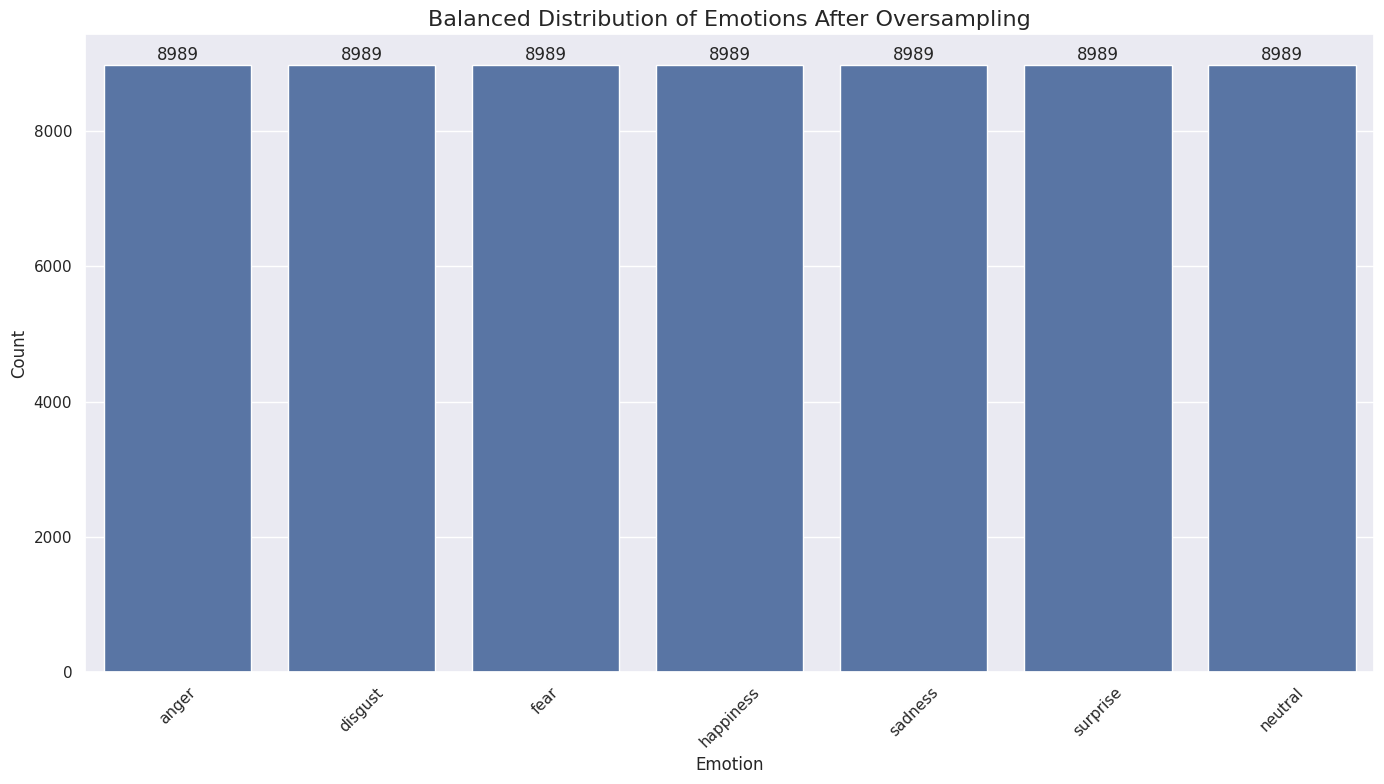

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the balanced emotion distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=y_data)  # y_data is the oversampled target variable

# Customize the plot
plt.title('Balanced Distribution of Emotions After Oversampling', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(7), labels=[label_to_text[i] for i in range(7)], rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(ax.patches):
    ax.text(v.get_x() + v.get_width()/2, v.get_height() + 5,
            str(int(v.get_height())),
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [8]:
x_data = pd.Series(x_data.flatten())
x_data

# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [9]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 7)
y_train.shape
y_test = to_categorical(y_test, 7)
y_test.shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

In [10]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.25),

     Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 256)           │              

 Total params: 1,115,975 (4.26 MB)

 Trainable params: 1,114,695 (4.25 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [11]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test))

print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

Epoch 1/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.2481 - loss: 1.8581 - val_accuracy: 0.4430 - val_loss: 1.4474
Epoch 2/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - accuracy: 0.4393 - loss: 1.4633 - val_accuracy: 0.5128 - val_loss: 1.2436
Epoch 3/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5180 - loss: 1.2599 - val_accuracy: 0.5605 - val_loss: 1.1501
Epoch 4/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.5652 - loss: 1.1342 - val_accuracy: 0.6134 - val_loss: 0.9990
Epoch 5/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5965 - loss: 1.0457 - val_accuracy: 0.6247 - val_loss: 0.9686
Epoch 6/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.6268 - loss: 0.9751 - val_accuracy: 0.6475 - val_loss: 0.9442
Epoch 7/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.6459 - loss: 0.9205 - val_accuracy: 0.6781 - val_loss: 0.8727
Epoch 8/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.6734 -

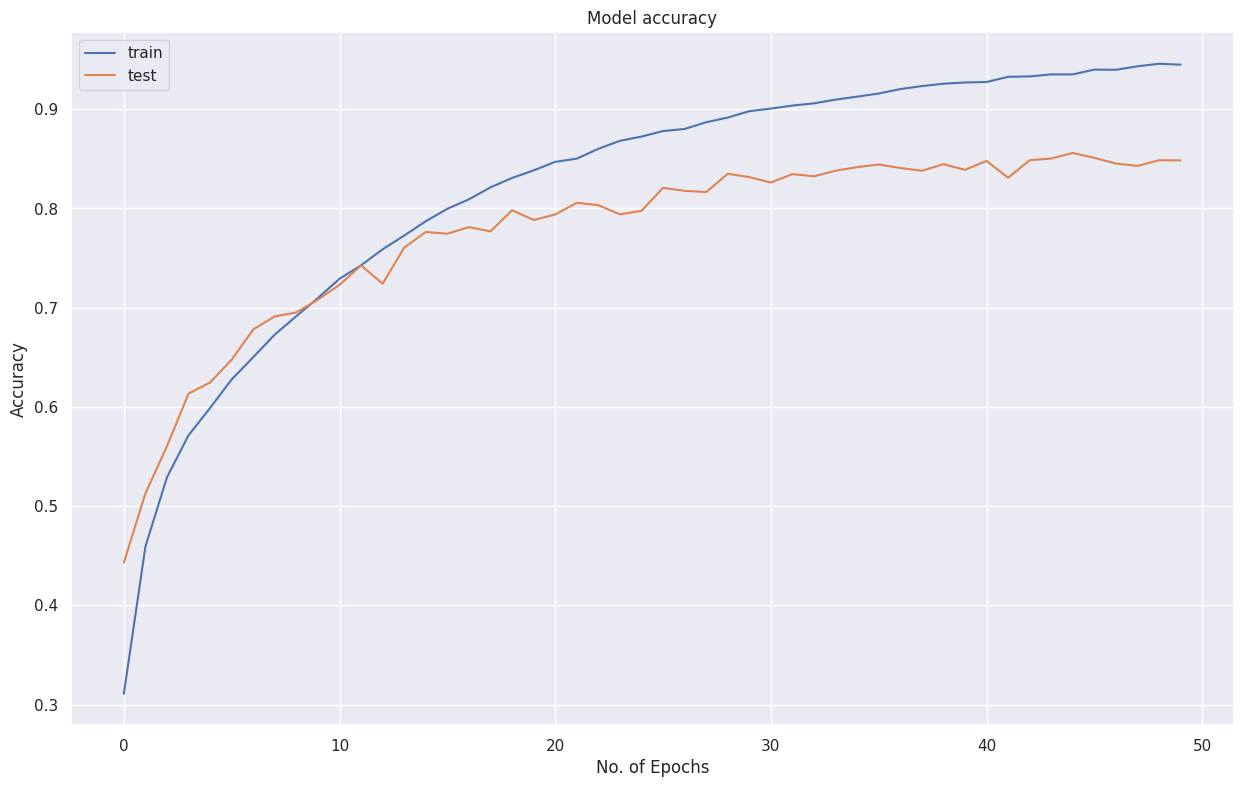

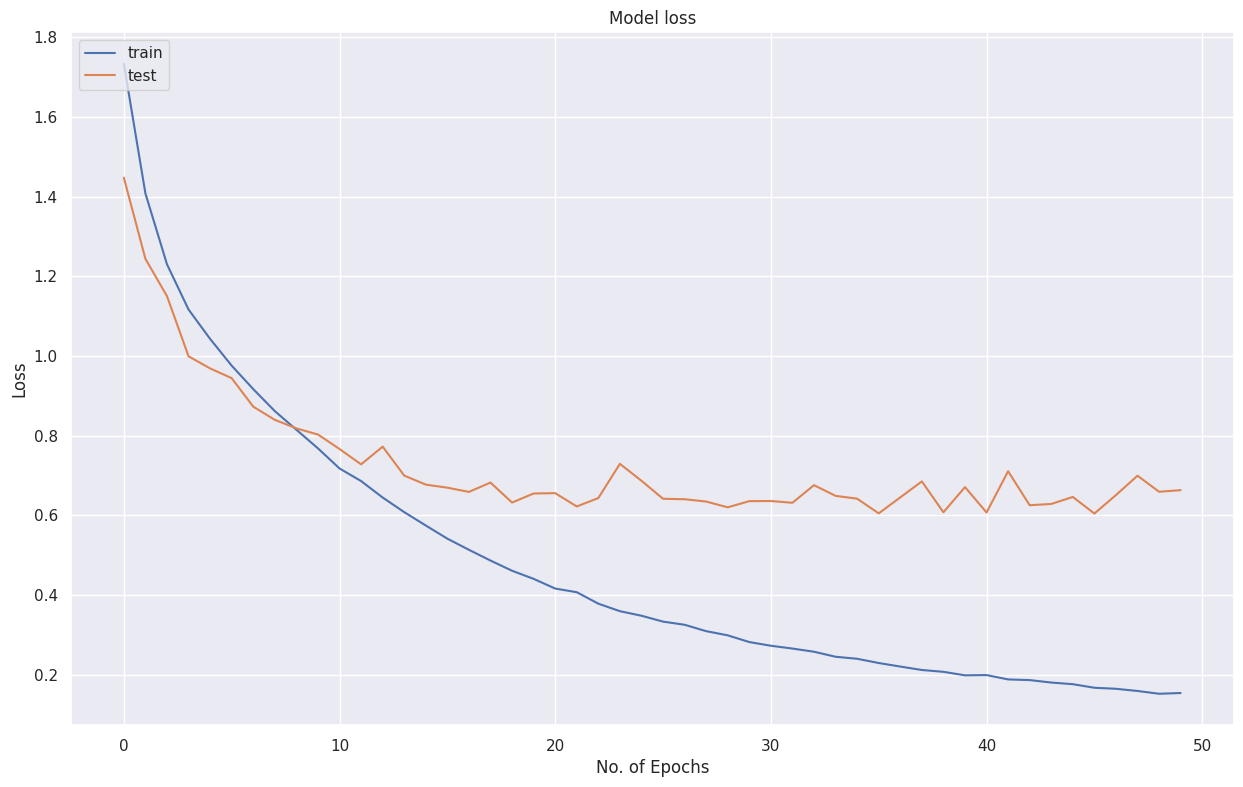

In [13]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


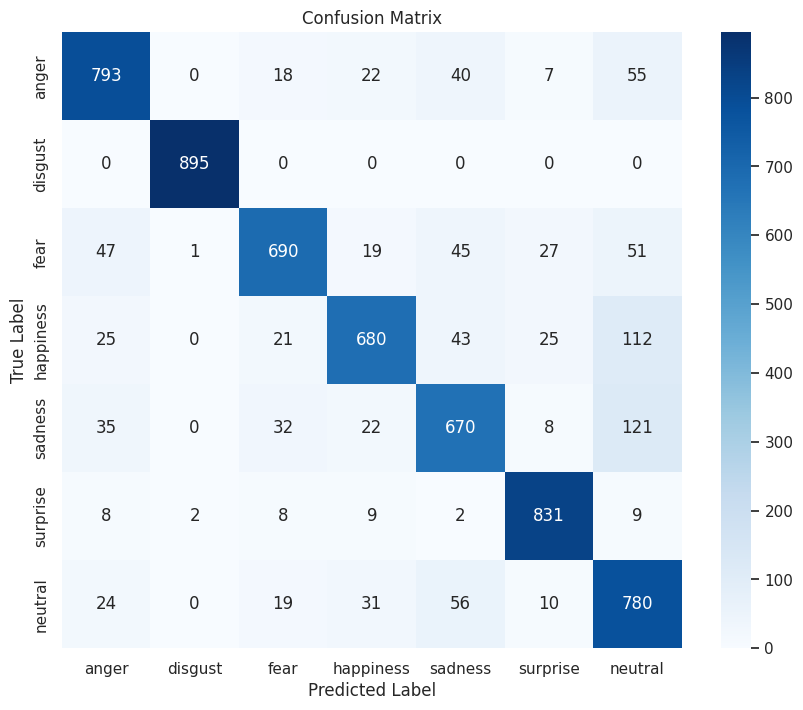

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.85      0.85       935
     disgust       1.00      1.00      1.00       895
        fear       0.88      0.78      0.83       880
   happiness       0.87      0.75      0.81       906
     sadness       0.78      0.75      0.77       888
    surprise       0.92      0.96      0.94       869
     neutral       0.69      0.85      0.76       920

    accuracy                           0.85      6293
   macro avg       0.85      0.85      0.85      6293
weighted avg       0.85      0.85      0.85      6293



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_text.values(), yticklabels=label_to_text.values())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_to_text.values()))

In [15]:
model.save('/content/drive/MyDrive/emotion_recognition_model.h5')
print("Model saved to Google Drive.")

Model saved to Google Drive.
